In [58]:
# List all device
from tensorflow.python.client import device_lib
# print(device_lib.list_local_devices())

In [59]:
# Check available GPU
from keras import backend as K
K.tensorflow_backend._get_available_gpus()

[]

In [60]:
import os
os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID";
# The GPU id to use, usually either "0" or "1";
os.environ["CUDA_VISIBLE_DEVICES"]="0";  

In [61]:
# Importing the libraries
import numpy as np
import pandas as pd
from keras.models import Sequential
from keras.layers import Dense, LSTM, Dropout, Reshape, Lambda, GRU, BatchNormalization
from keras.preprocessing.sequence import TimeseriesGenerator
from keras.callbacks import EarlyStopping, ModelCheckpoint
from keras.activations import softmax
from keras.optimizers import SGD, RMSprop
import math
import pickle
import matplotlib.pyplot as plt
from keras.utils import to_categorical

In [62]:
with open("../data/dowjones_calculated/periods750_250_240.txt", "rb") as fp:   # Unpickling
    dataset = pickle.load(fp)

In [63]:
def normalize_data(df):
    """normalize a dataframe."""
    mean = df.mean(axis=1)
    std = df.std(axis=1)
    df = df.sub(mean, axis=0)
    df = df.div(std, axis=0)
    df = df.values
    return df
def get_one_hot(targets, nb_classes):
    res = np.eye(nb_classes)[np.array(targets).reshape(-1)]
    return res.reshape(list(targets.shape)+[nb_classes])

In [64]:
i = 5
timestep = 240

In [65]:
# x_train = dataset[0][i][0]['AMZN'].values * 1000
# y_train = dataset[0][i][1]['AMZN'].values * 1.0
# x_test = dataset[1][i][0]['AMZN'].values * 1000
# y_test = dataset[1][i][1]['AMZN'].values * 1.0

# x_train = dataset[0][i][0].values
# x_train = (x_train - x_train.mean())/x_train.std()
# y_train = dataset[0][i][1].values * 1.0
# x_test = dataset[1][i][0].values
# x_test = (x_test - x_test.mean())/x_test.std()
# y_test = dataset[1][i][1].values * 1.0

x_train = dataset[0][i][0].values * 1000
x_test = dataset[1][i][0].values * 1000
# y_train = get_one_hot(dataset[0][i][1].values, 2) * 1.0
# y_test = get_one_hot(dataset[1][i][1].values, 2) * 1.0
y_train = to_categorical(dataset[0][i][1].values, 2)
y_test = to_categorical(dataset[1][i][1].values, 2)

In [66]:
print(f"x train shape: {x_train.shape}")
print(f"y train shape: {y_train.shape}")
print(f"x test shape: {x_test.shape}")
print(f"y test shape: {y_test.shape}")

x train shape: (750, 31)
y train shape: (750, 31, 2)
x test shape: (490, 31)
y test shape: (490, 31, 2)


In [67]:
# The second range will be looped first
# x_series = [x_train[i:i+240] for i in range(750 - 240)]
# y_series = [y_train[i+240] for i in range(750 - 240)]
# x_series = [x_train[i:i+240, j] for j in range(31) for i in range(750 - 240)]
# y_series = [y_train[i+240, j] for j in range(31) for i in range(750 - 240)]
x_series = [x_train[i:i+240, j] for i in range(750 - 240) for j in range(31)]
y_series = [y_train[i+240, j] for i in range(750 - 240) for j in range(31)]
x = np.array(x_series)
y = np.array(y_series)
print(f"x shape: {x.shape}")
print(f"y shape: {y.shape}")

x shape: (15810, 240)
y shape: (15810, 2)


In [68]:
# x = x.transpose((0,2,1))
# x = np.reshape(x, (510 * 31, timestep))
# y = np.reshape(y, (510 * 31, 2))
print(f"x shape: {x.shape}")
print(f"y shape: {y.shape}")

x shape: (15810, 240)
y shape: (15810, 2)


In [69]:
x = np.reshape(x, (x.shape[0], x.shape[1], 1))
print(f"x shape: {x.shape}")


x shape: (15810, 240, 1)


In [70]:

x_train = normalize_data(dataset[0][i][0])
# y_train = get_one_hot(dataset[0][i][1].values, 2) * 1.0
x_test = normalize_data(dataset[1][i][0])
# y_test = get_one_hot(dataset[1][i][1].values, 2) * 1.0

y_train = dataset[0][i][1].values * 1.0
y_test = dataset[1][i][1].values * 1.0

train_gen = TimeseriesGenerator(x_train, y_train,
                                length=timestep, sampling_rate=1,
                                batch_size=10)
test_gen = TimeseriesGenerator(x_test, y_test,
                               length=timestep, sampling_rate=1,
                               batch_size=10)

In [71]:
print(f"x train shape: {x_train.shape}")
print(f"y train shape: {y_train.shape}")
print(f"x test shape: {y_test.shape}")
print(f"y test shape: {y_test.shape}")
# print(f"predicted shape: {predicted.shape}")

x train shape: (750, 31)
y train shape: (750, 31)
x test shape: (490, 31)
y test shape: (490, 31)


In [76]:
dropout_rate = 0.1
# expected input data shape: (batch_size, timesteps, data_dim)
regressor = Sequential()
# regressor.add(LSTM(units=25, input_shape=(timestep, 1), dropout=0.1))
# regressor.add(GRU(units=25, return_sequences=True, input_shape=(timestep, 1), dropout=0.3, recurrent_dropout=0.3))
# regressor.add(GRU(25, return_sequences=True, dropout=0.3))
# regressor.add(GRU(25, dropout=0.3, recurrent_dropout=0.3))

# regressor.add(GRU(units=250, return_sequences=True, input_shape=(timestep, 1), dropout=dropout_rate, recurrent_dropout=dropout_rate))
# regressor.add(GRU(250, dropout=dropout_rate, recurrent_dropout=dropout_rate))
# regressor.add(LSTM(units=100, return_sequences=True, batch_input_shape=(10, timestep, 31), dropout=dropout_rate, recurrent_dropout=dropout_rate, stateful = True))
regressor.add(LSTM(units=25, batch_input_shape=(527, timestep, 1), dropout=dropout_rate, recurrent_dropout=dropout_rate, stateful = True))
# regressor.add(BatchNormalization())
# regressor.add(LSTM(5, dropout=dropout_rate, recurrent_dropout=dropout_rate, stateful = True))
# regressor.add(BatchNormalization())

# regressor.add(LSTM(units=150, return_sequences=True, input_shape=(timestep, 1), dropout=dropout_rate, recurrent_dropout=dropout_rate))
# regressor.add(LSTM(150, dropout=dropout_rate, recurrent_dropout=dropout_rate))
# regressor.add(Dense(10,input_shape=(timestep, ), activation='relu'))
# regressor.add(Dense(100, activation='relu'))
# regressor.add(Dense(50, activation='relu'))

# regressor.add(Dense(62, activation='relu'))
# regressor.add(Reshape((31, 2)))
# regressor.add(Lambda(lambda x: softmax(x, axis=-1)))

regressor.add(Dense(2, activation='softmax'))
# regressor.add(Dense(1, activation='sigmoid'))
# regressor.add(Dense(1, activation='sigmoid'))
# regressor.compile(loss='mean_squared_error',
#                   optimizer='rmsprop',
#                   metrics=['accuracy'])
# RMSprop = RMSprop(lr=0.01)
# regressor.compile(loss='binary_crossentropy',
#                   optimizer=RMSprop,
#                   metrics=['accuracy'])

regressor.compile(loss='binary_crossentropy',
                  optimizer='rmsprop',
                  metrics=['accuracy'])
regressor.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_11 (LSTM)               (527, 25)                 2700      
_________________________________________________________________
dense_10 (Dense)             (527, 2)                  52        
Total params: 2,752
Trainable params: 2,752
Non-trainable params: 0
_________________________________________________________________


In [77]:

result = regressor.fit(x, y, epochs=1000,batch_size=527, validation_split=0.2, shuffle=False, callbacks = [EarlyStopping(monitor='val_loss', mode='min', patience=10),
             ModelCheckpoint(filepath='../model/LSTM/best_model.h5', monitor='val_acc', save_best_only=True)])

# regressor.fit(x, y, epochs=1000,batch_size=500, validation_split=0.2, callbacks = [EarlyStopping(monitor='val_loss', mode='min', patience=20),
#              ModelCheckpoint(filepath='../model/LSTM/best_model.h5', monitor='val_acc', save_best_only=True)])

# regressor.fit_generator(train_gen, steps_per_epoch=len(train_gen),
#                         epochs=100, validation_data=test_gen,
#                         callbacks=[
#                             EarlyStopping(monitor='val_loss',
#                                           mode='min', patience=100),
#                             ModelCheckpoint(filepath="../model/mymodel.h5",
#                                             monitor='val_acc',
#                                             save_best_only=True)])

Train on 12648 samples, validate on 3162 samples
Epoch 1/1000
12648/12648 [==============================] - 4s 343us/step - loss: 0.6981 - acc: 0.5020 - val_loss: 0.6944 - val_acc: 0.5149
Epoch 2/1000
12648/12648 [==============================] - 3s 257us/step - loss: 0.6936 - acc: 0.5138 - val_loss: 0.6942 - val_acc: 0.5117
Epoch 3/1000
12648/12648 [==============================] - 3s 258us/step - loss: 0.6933 - acc: 0.5154 - val_loss: 0.6939 - val_acc: 0.5082
Epoch 4/1000
12648/12648 [==============================] - 3s 261us/step - loss: 0.6933 - acc: 0.5145 - val_loss: 0.6935 - val_acc: 0.5136
Epoch 5/1000
12648/12648 [==============================] - 3s 262us/step - loss: 0.6922 - acc: 0.5194 - val_loss: 0.6938 - val_acc: 0.5089
Epoch 6/1000
12648/12648 [==============================] - 3s 260us/step - loss: 0.6924 - acc: 0.5139 - val_loss: 0.6930 - val_acc: 0.5092
Epoch 7/1000
12648/12648 [==============================] - 3s 270us/step - loss: 0.6922 - acc: 0.5185 - val_lo

In [78]:
# result.history

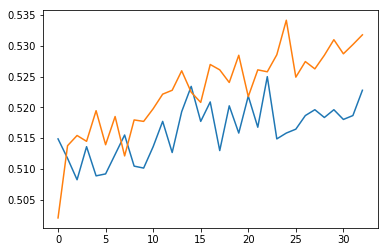

In [79]:
plt.plot(result.history["val_acc"])
plt.plot(result.history["acc"])

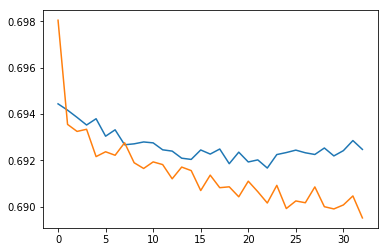

In [80]:
plt.plot(result.history["val_loss"])
plt.plot(result.history["loss"])